In [1]:
cd ../

c:\Users\andre\Documents\GitHub\OCTA


In [2]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
IMAGE_SIZE = [224, 224]

In [4]:
images_path = 'images'
train_path = images_path+'/train'
test_path = images_path+'/test'

In [5]:
from bin.util import get_filenames_from_folder

folder = train_path+'/normal'

normal_files = get_filenames_from_folder(folder)
rain_files = get_filenames_from_folder(train_path+'/rain')
print(f"{len(normal_files)} images of normal situation")
print(f"{len(rain_files)} images of rain")


17751 images of normal situation
47155 images of rain


In [7]:
vgg = VGG16(input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3), weights='imagenet', include_top=True)

ImportError: DLL load failed while importing defs: The specified procedure could not be found.

In [ ]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
folders = glob(train_path+'/*')
print(len(folders))

2


In [ ]:
x = Flatten()(vgg.output)
activation_func = 'softmax'
prediction = Dense(len(folders), activation=activation_func)(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras import optimizers
from keras import metrics

metric = metrics.MeanIoU(len(folders)) # Intersection-over-union a.k.a. Jaccard Index
adam = optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=metric)

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
# test_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest')
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
batch_size = 32

train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

Found 62102 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

Found 7492 images belonging to 2 classes.


In [ ]:
def scheduler(epoch:int, learning_rate):
    if epoch < 10:
        return learning_rate
    if epoch % 2 == 0:
        return learning_rate/10
    return learning_rate

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from bin.util import current_time



monitor = "val_loss"
patience = 5
verbose = 2
steps_epoch = test_set.__len__()

file_path = f'models/vgg_dense_{activation_func}_batch{batch_size}_steps{steps_epoch}_{current_time()}.h5'

checkpoint = ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=verbose, save_best_only=True)
es = EarlyStopping(monitor=monitor,
                         patience=patience,
                         verbose=verbose,
                         mode='min',
                         restore_best_weights=True)
lrs = LearningRateScheduler(scheduler)
callbacks = [es, lrs, checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=100,
  steps_per_epoch=steps_epoch,
  # validation_steps=32,
  callbacks=callbacks,
  verbose=2)

duration = datetime.now() - start
print("Training completed in time: ", duration)

C:\Users\andre\AppData\Local\Temp\ipykernel_13040\2082123320.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history=model.fit_generator(


Epoch 1/100

Epoch 1: val_loss improved from inf to 0.81139, saving model to models\vgg_dense_softmax_2023-06-06_15-25-32.h5
5/5 - 177s - loss: 8.3550 - mean_io_u: 0.5241 - val_loss: 0.8114 - val_mean_io_u: 0.7286 - lr: 0.0010 - 177s/epoch - 35s/step
Epoch 2/100

Epoch 2: val_loss did not improve from 0.81139
5/5 - 185s - loss: 3.7599 - mean_io_u: 0.5179 - val_loss: 7.1146 - val_mean_io_u: 0.2559 - lr: 0.0010 - 185s/epoch - 37s/step
Epoch 3/100

Epoch 3: val_loss improved from 0.81139 to 0.63139, saving model to models\vgg_dense_softmax_2023-06-06_15-25-32.h5
5/5 - 188s - loss: 2.6136 - mean_io_u: 0.7013 - val_loss: 0.6314 - val_mean_io_u: 0.9022 - lr: 0.0010 - 188s/epoch - 38s/step
Epoch 4/100

Epoch 4: val_loss improved from 0.63139 to 0.22027, saving model to models\vgg_dense_softmax_2023-06-06_15-25-32.h5
5/5 - 189s - loss: 2.1246 - mean_io_u: 0.7330 - val_loss: 0.2203 - val_mean_io_u: 0.9157 - lr: 0.0010 - 189s/epoch - 38s/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0

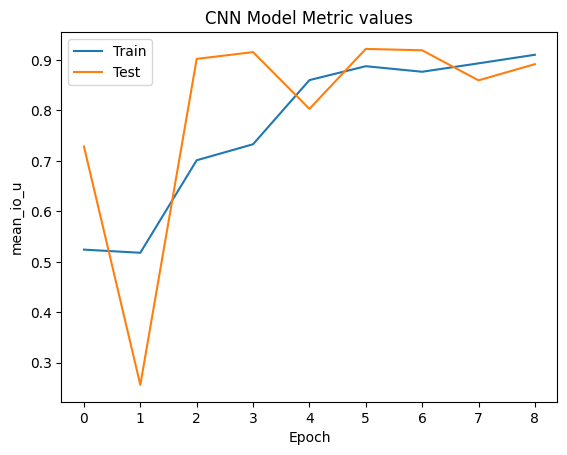

In [ ]:
# Plot training & validation loss values
plt.plot(model_history.history[metric.name])
plt.plot(model_history.history['val_'+metric.name])
plt.title('CNN Model Metric Values')
plt.ylabel(metric.name)
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
